# KNN Tuning implementation on Iris Dataset

## Importing Libraries and Dataset

In [190]:
import pandas as pd
import numpy as np
from scipy.stats import mode

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# Dataset
from sklearn.datasets import load_iris

# Spltting
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error

In [191]:
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Exploring Dataset

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


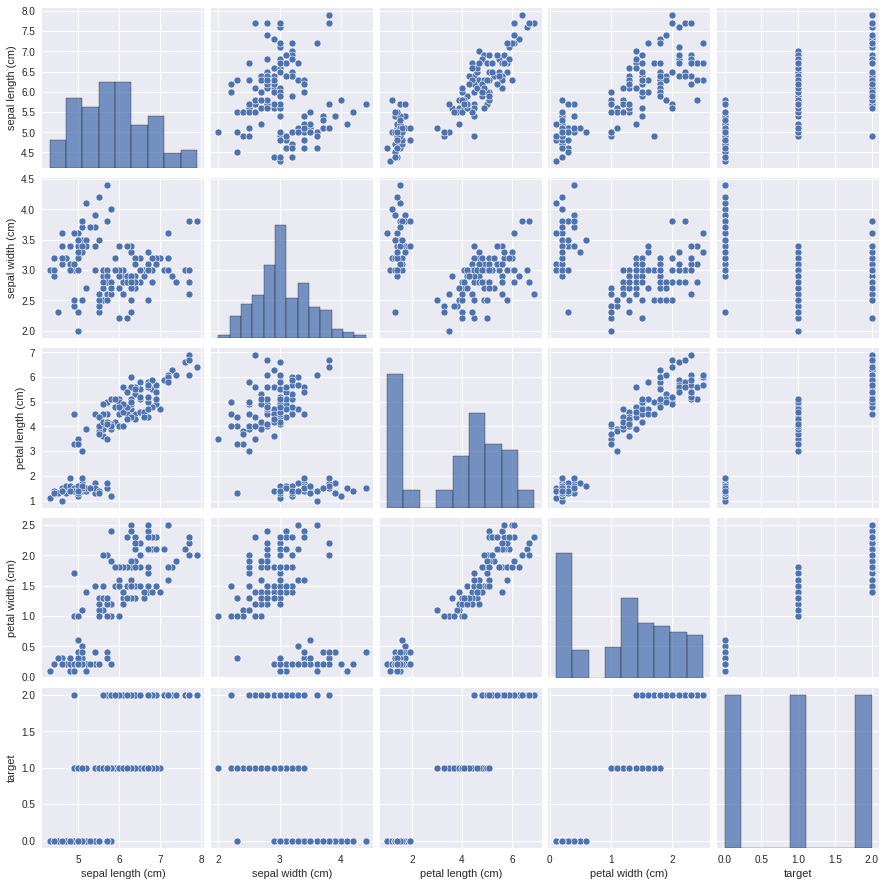

In [193]:
sns.pairplot(df)
plt.show()

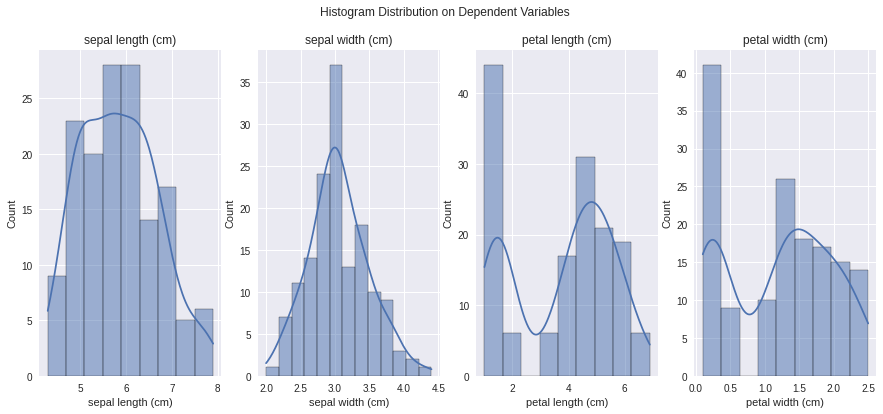

In [194]:
fig, ax = plt.subplots(1,4, figsize=(15,6))
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

for i in range(len(features)):
  sns.histplot(df[features[i]], ax=ax[i], kde=True)
  ax[i].set_title(features[i])

plt.suptitle('Histogram Distribution on Dependent Variables')
plt.show()

> As we can see here, the distribution relatively normal on sepal length and width, and from the number scaling, it seems like that the number scaling between each dependent variable is not really far, which means scaling won't change much on this dataset.

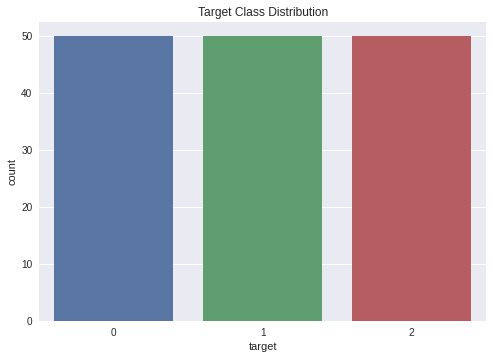

In [195]:
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution')
plt.show()

> As we can see, the target variable is distributed well enough in each class, which means, our dataset is balanced. Therefore, since the distribution is normal, we will use **Root Mean Squared Error** as our error function to determine whether our model perform well or not.

## 1. First Question
> Tune k-NN. Try larger and larger k values to see if you can improve the performance of the algorithm on the Iris Dataset

### Splitting Datasets

In [196]:
target = 'target'
X = iris.data
y = iris.target

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [198]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (120, 4)
X_test shape (30, 4)
y_train shape (120,)
y_test shape (30,)


### Modelling

In [199]:
class KNN:
  def __init__(self, k, distance_measure, problem):
    self.k = k
    self.distance_measure = distance_measure
    self.problem = problem

  def distance_function(self,a, b,p):
    
    dimension = len(a)

    # Hamming Distance Measures
    if p == -1:
      distance_hamming = 0
      for i in range(dimension):
        if a[i] != b[i]:
          distance_hamming += 1

      return distance_hamming

    # Minkowski, Euclidian, Manhattan Distance Measures
    distance = 0
    for i in range(dimension):
      distance += abs(a[i] - b[i])**p
    
    distance = distance**(1/p)

    return distance
  
  def predict(self, X_train, X_test, y_train):
    
    predict_answer = []

    if self.distance_measure == 'manhattan':
      p=1
    elif self.distance_measure == 'euclidian':
      p=2
    elif self.distance_measure == 'minkowski':
      p=3
    else:
      p=-1

    for test_data in X_test:
      distances = []

      for t in range(len(X_train)):
        distance = self.distance_function(test_data, X_train[t], p)
        distances.append(distance)

      distances = np.array(distances)

      # Sorting and Voting
      df_sort = np.argsort(distances)[:self.k]
      neighbor = y_train[df_sort]

      if self.problem == 'classification':
        prediction = mode(neighbor)
        prediction = prediction.mode[0]

      elif self.problem == 'regression':
        prediction = np.mean(neighbor)
      
      predict_answer.append(prediction)
    return predict_answer

### Tuning KNN to obtain optimum *K* value

> For first model, we will use Euclidian distance as default distance measure.

#### Error

In [200]:
error = []
for k in range(1, 30):
  model = KNN(k, 'euclidian', 'classification')
  pred = model.predict(X_train, X_test, y_train)
  error.append(np.sqrt(mean_squared_error(y_test, pred)))

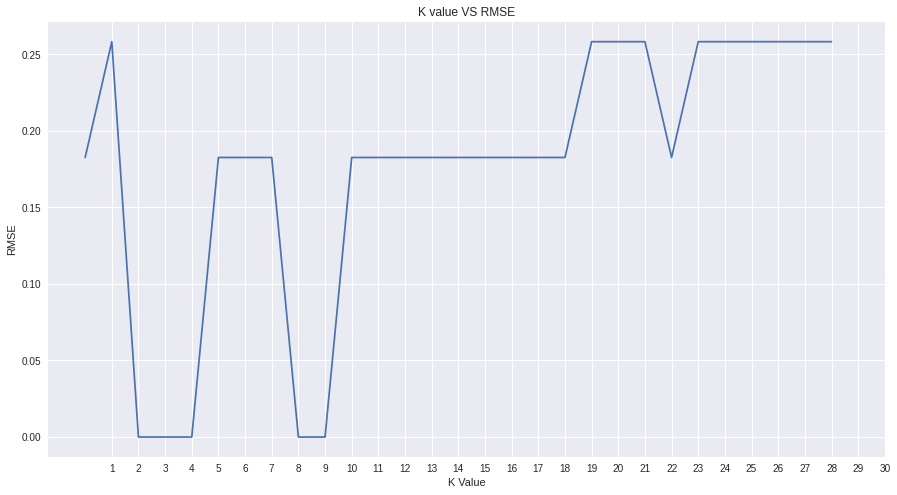

In [201]:
plt.figure(figsize=(15,8))
plt.plot(error)
plt.title('K value VS RMSE')
plt.xticks(np.arange(1,31))
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.show()

#### Accuracy

In [202]:
accuracy = []
for k in range(1,30):
  model = KNN(k, 'euclidian', 'classification')
  pred = model.predict(X_train, X_test, y_train)
  accuracy.append(accuracy_score(y_test, pred))

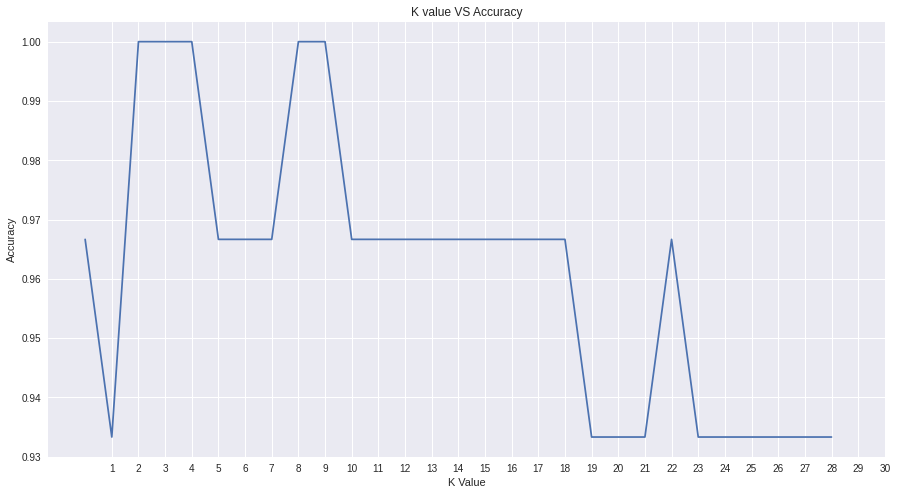

In [203]:
plt.figure(figsize=(15,8))
plt.plot(accuracy)
plt.title('K value VS Accuracy')
plt.xticks(np.arange(1,31))
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()

> There are various K value with highest accuracy, let's take 9 for our final K value since it produces 100% accuracy and 0 RMSE.

### Confusion Matrix on 9-Nearest Neighbor

In [204]:
model_euclidian = KNN(9, 'euclidian', 'classification')
prediction = model_euclidian.predict(X_train, X_test, y_train)

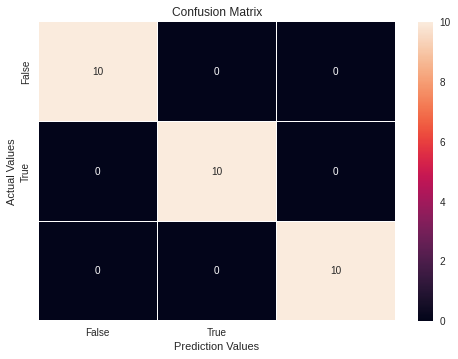

In [205]:
cf = confusion_matrix(y_test, prediction)
ax = sns.heatmap(cf, annot=True, linewidth=0.1)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

### Evaluation Score

In [206]:
TRUTH_VALUE = y_test
print(f'\nClassification Score:\n {classification_report(TRUTH_VALUE, prediction)}')


Classification Score:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



> It was proven that K = 9 produces a perfect score in our model on Iris Dataset.

## 2. Second Question
> Implementing other distance measures.

In [207]:
# K Value
K_value = 9

In [208]:
# Confusion Matrix
def cf_m(test, pred, type):
  cf = confusion_matrix(test, pred)
  ax = sns.heatmap(cf, annot=True, linewidth=0.1)

  ax.set_title(f'Confusion Matrix on {type} Distance')
  ax.set_xlabel('Prediction Values')
  ax.set_ylabel('Actual Values')

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  plt.show()

In [209]:
# Classification Report
def cr(y_test, pred):
  TRUTH_VALUE = y_test
  print(f'\nClassification Score:\n {classification_report(TRUTH_VALUE, pred)}')

### Hamming Distance

In [210]:
model_hamming = KNN(K_value, 'hamming','classification')
pred_hamming = model_hamming.predict(X_train, X_test, y_train)

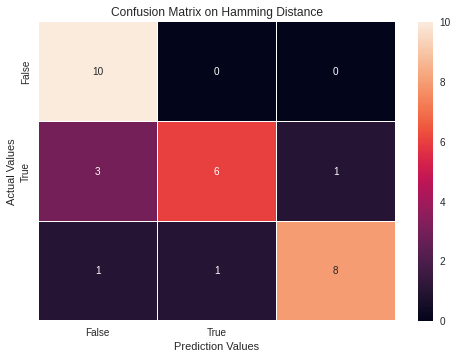

In [211]:
cf_m(y_test, pred_hamming, 'Hamming')

In [212]:
cr(y_test, pred_hamming)


Classification Score:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.86      0.60      0.71        10
           2       0.89      0.80      0.84        10

    accuracy                           0.80        30
   macro avg       0.82      0.80      0.79        30
weighted avg       0.82      0.80      0.79        30



### Manhattan Distance

In [213]:
model_manhattan = KNN(K_value, 'manhattan','classification')
pred_manhattan = model_manhattan.predict(X_train, X_test, y_train)

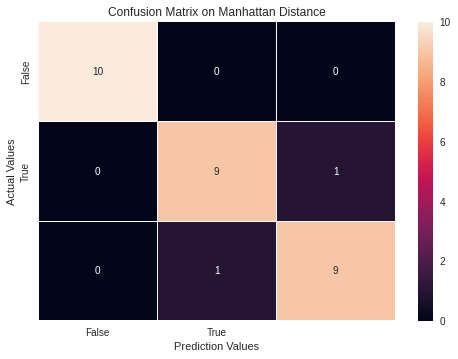

In [214]:
cf_m(y_test, pred_manhattan, 'Manhattan')

In [215]:
cr(y_test, pred_manhattan)


Classification Score:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



### Minkowski Distance

In [216]:
model_minkowski = KNN(K_value, 'minkowski','classification')
pred_minkowski = model_minkowski.predict(X_train, X_test, y_train)

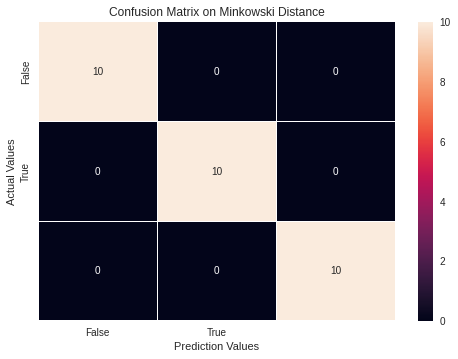

In [217]:
cf_m(y_test, pred_minkowski, 'Minkowski')

In [218]:
cr(y_test, pred_minkowski)


Classification Score:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



> It seems like Minkowski Distance Measures also produces a perfect score on our KNN model with Iris Dataset

## Third Question
> Regression

In [219]:
data = pd.read_csv('https://raw.githubusercontent.com/DnYAlv/Intelligent_System/main/KNN/Housing.csv')

In [220]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### Exploring the Dataset

In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [222]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


#### Missing Values

In [223]:
data.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

> Seems like there are no missing values on the dataset

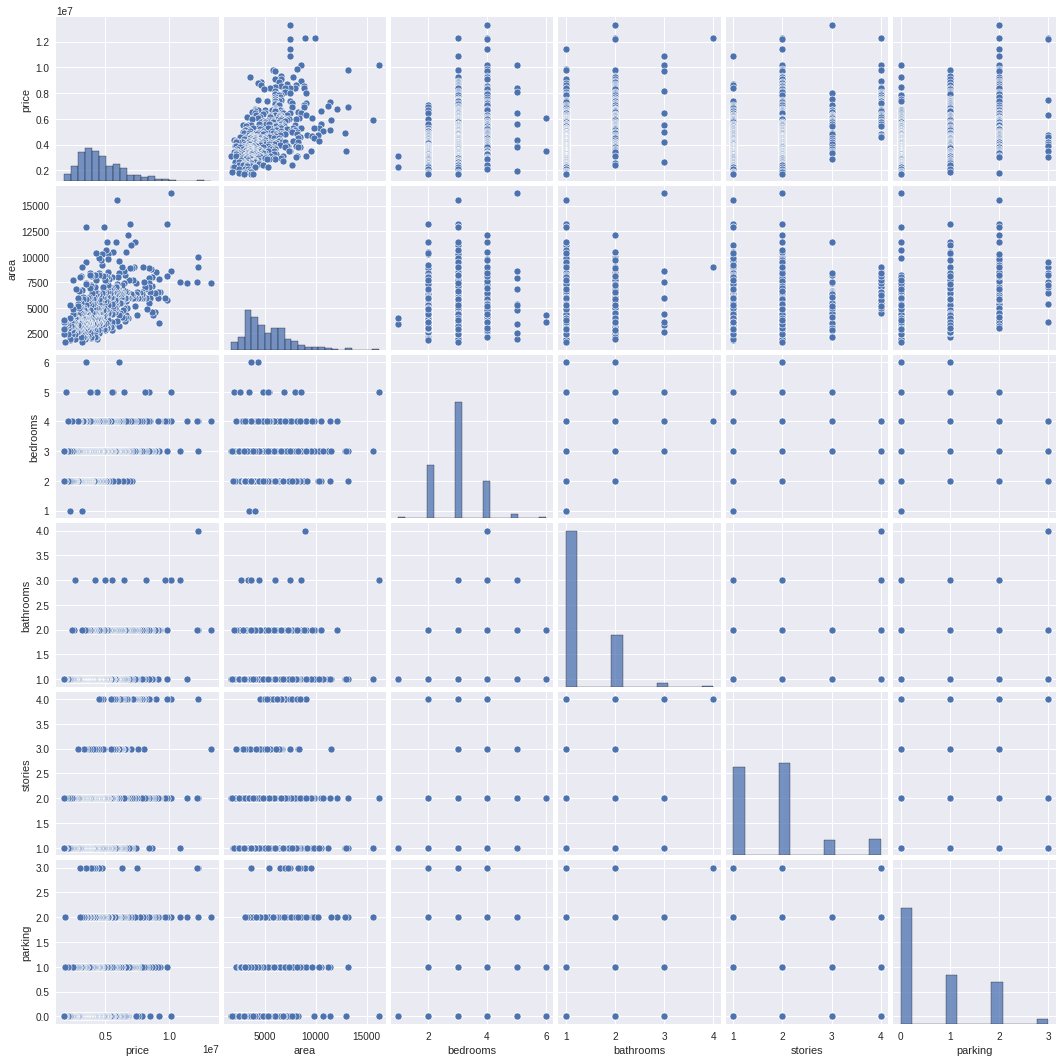

In [224]:
sns.pairplot(data)
plt.show()

> Seems like this dataset most likely contain categorical variable (even though in numerical form (nominal variables)).

#### Checking Outliers

- On Variable 'area'

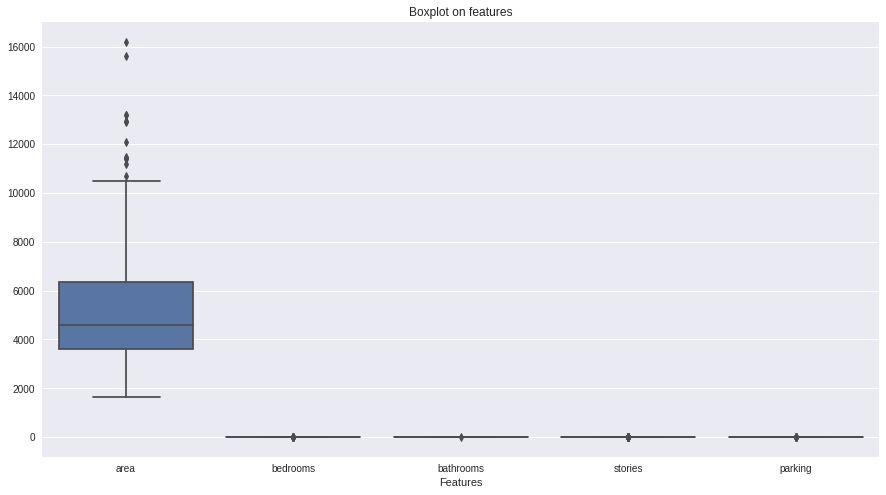

In [225]:
features = ['area','bedrooms','bathrooms','stories','parking']

plt.figure(figsize=(15,8))
sns.boxplot(data=data[features])
plt.xlabel('Features')
positions = (0,1,2,3,4)
labels = ('area','bedrooms','bathrooms','stories','parking')
plt.title('Boxplot on features')
plt.xticks(positions, labels)
plt.show()

> It seems like the scale number in 'area' is too big when being differentiated between others. It was in fact true, since other variables such as 'bedrooms', 'bathrooms', 'stories', and 'parking' was actually a nominal variable.

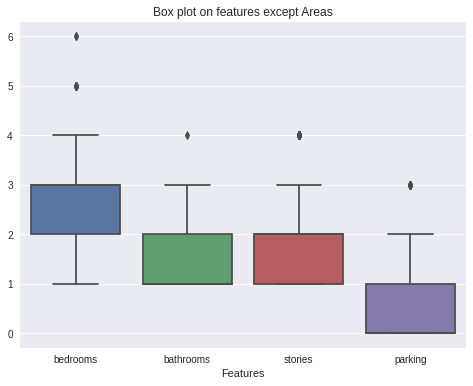

In [226]:
features = ['bedrooms','bathrooms','stories','parking']

plt.figure(figsize=(8,6))
sns.boxplot(data=data[features])
plt.xlabel('Features')
positions = (0,1,2,3)
labels = ('bedrooms','bathrooms','stories','parking')
plt.title('Box plot on features except Areas')
plt.xticks(positions, labels)
plt.show()

> It may or may not an outliers, let's check it out with other visualization

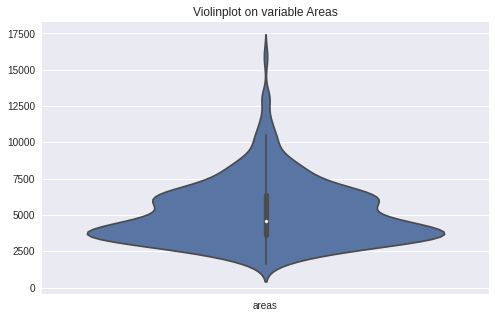

In [227]:
plt.figure(figsize=(8,5))
sns.violinplot(data=data['area'])
plt.title('Violinplot on variable Areas')
plt.xticks([0],['areas'])
plt.show()

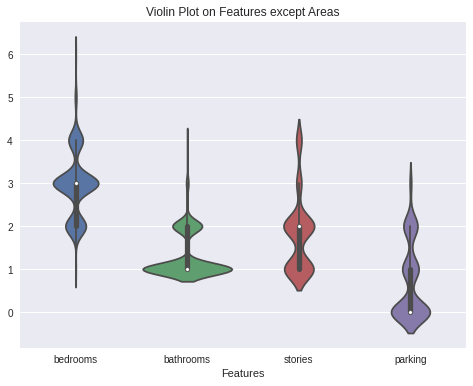

In [228]:
features = ['bedrooms','bathrooms','stories','parking']

plt.figure(figsize=(8,6))
sns.violinplot(data=data[features])
plt.xlabel('Features')
positions = (0,1,2,3)
labels = ('bedrooms','bathrooms','stories','parking')
plt.title('Violin Plot on Features except Areas')
plt.xticks(positions, labels)
plt.show()

> From the visualization above, we can conclude that, it wasn't an outliers since we can see some density. Therefore, we don't need to do some handling in outliers, buy scaling or normalization may come in handy.

#### Target Variable Distributions

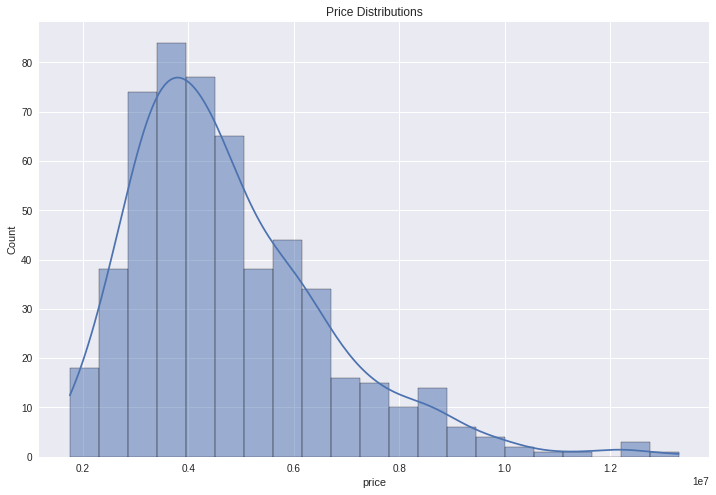

In [229]:
plt.figure(figsize=(12,8))
sns.histplot(data['price'], kde=True)
plt.title('Price Distributions')
plt.show()

> From the visualization above, we can see that the distribution on target variable most likely to be right skewed, which means we can have **Mean Absolute Error** as our main metric to determine how well our model can perform on this dataset since MAE gives lesser penalty to the outlier of target variable on the dataset. We can add some other metrics such as MSE, RMSE, but mainly focus on MAE.

### Preprocessing

#### Encoding Categorical Data

In [230]:
two_categorical_data = ['mainroad', 'guestroom','basement','hotwaterheating',
                    'airconditioning','prefarea']

for d in two_categorical_data:
  data[d] = data[d].map({
      'yes':1,
      'no':0
  })

data['furnishingstatus'] = data['furnishingstatus'].map({
    'furnished':2,
    'semi-furnished':1,
    'unfurnished':0
})


#### Checking Correlation

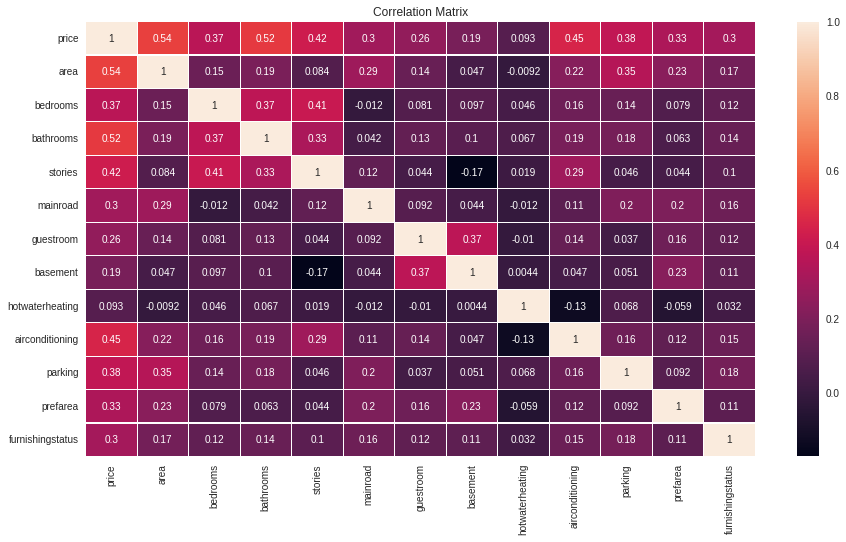

In [231]:
plt.figure(figsize=(15,8))
sns.heatmap(data=data.corr(), annot=True, linewidth=0.1)
plt.title('Correlation Matrix')
plt.show()

> Having 'price' as our target variables, we can find out that there are such strongly correlated feature to our target variables such as:
- area
- bathrooms
- stories

>Less than (0.5 but may be reconsidered)
- airconditioning
- bedrooms
- parking

Therefore, we can drop other features that have weak correlation to target variables.

#### Feature Selection

In [232]:
columns = ['area','bathrooms','stories','airconditioning','parking','bedrooms','price']
data = data[columns]
data.head()

,area,bathrooms,stories,airconditioning,parking,bedrooms,price
0,7420,2,3,1,2,4,13300000
1,8960,4,4,1,3,4,12250000
2,9960,2,2,0,2,3,12250000
3,7500,2,2,1,3,4,12215000
4,7420,1,2,1,2,4,11410000


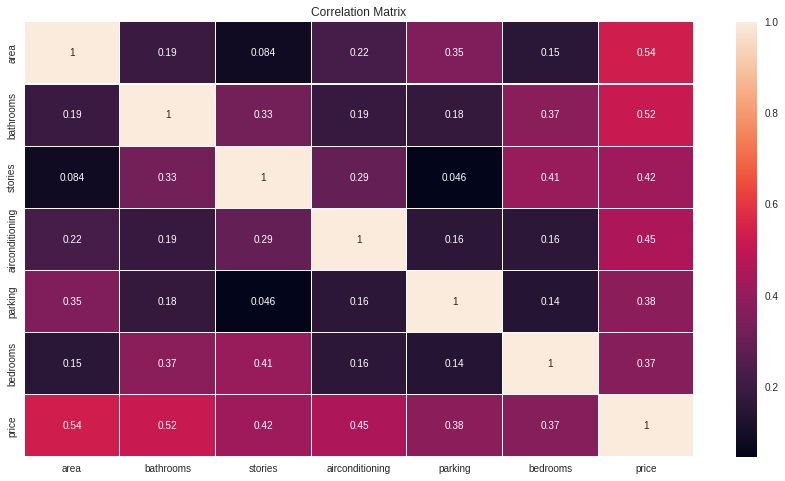

In [233]:
plt.figure(figsize=(15,8))
sns.heatmap(data=data.corr(), annot=True, linewidth=0.1)
plt.title('Correlation Matrix')
plt.show()

### Splitting Dataset

In [234]:
X = data[['area','bathrooms','stories','airconditioning','parking','bedrooms']]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
print(f'X_train shape = {X_train.shape}')
print(f'X_test shape = {X_test.shape}')
print(f'y_train shape = {y_train.shape}')
print(f'y_test shape = {y_test.shape}')

X_train shape = (436, 6)
X_test shape = (109, 6)
y_train shape = (436,)
y_test shape = (109,)


### Modelling using KNN

#### Finding Optimal *K* Value for KNN

In [235]:
error_mae = []
error_mse = []
error_rmse = []
for k in range(1, 30):
  model = KNN(k, 'euclidian', 'regression')
  pred = model.predict(np.array(X_train), np.array(X_test), np.array(y_train))
  error_mae.append(mean_absolute_error(y_test, pred))
  error_mse.append(mean_squared_error(y_test, pred))
  error_rmse.append(np.sqrt(mean_squared_error(y_test, pred)))

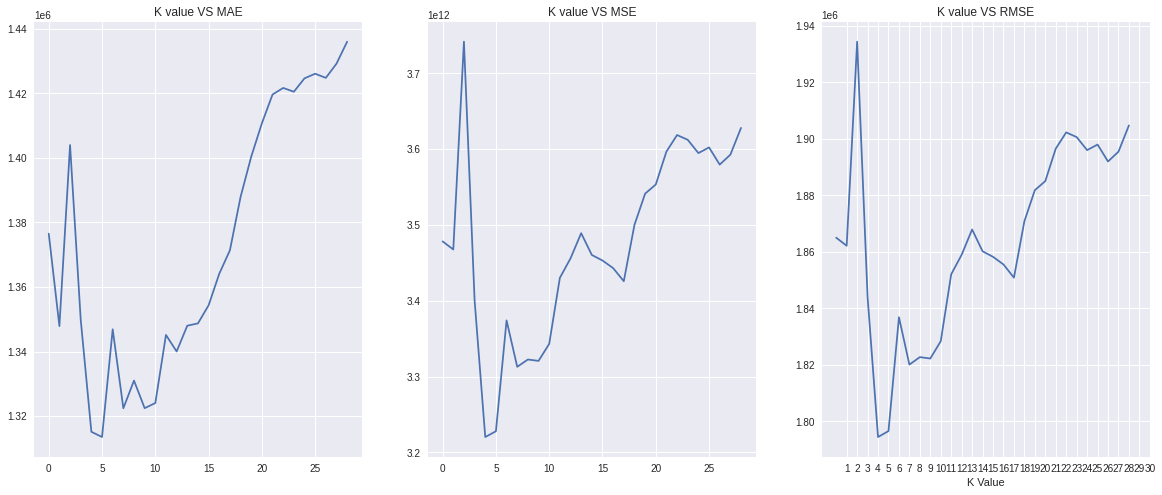

In [236]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
errors = [error_mae, error_mse, error_rmse]
labels = ['MAE', 'MSE', 'RMSE']
for e in range(len(errors)):
  ax[e].plot(errors[e])
  ax[e].set_title(f'K value VS {labels[e]}')
  plt.xticks(np.arange(1,31))
  plt.xlabel('K Value')
  
plt.show()

> From this, we can conclude that k = 5 produce the lowest MAE which means the optimal model.

#### Building 5-Nearest Neighbors

In [237]:
model_5nn = KNN(5, 'euclidian', 'regression')
pred_5nn = model_5nn.predict(np.array(X_train), np.array(X_test), np.array(y_train))
print(f'Mean Absolute Error : {mean_absolute_error(y_test, pred_5nn)}')
print(f'Mean Squared Error : {mean_squared_error(y_test, pred_5nn)}')
print(f'Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, pred_5nn))}')

Mean Absolute Error : 1315177.9816513762
Mean Squared Error : 3220155531009.1743
Root Mean Squared Error : 1794479.1809907337


## Fourth Question
> Applying Standardization

In [238]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [239]:
model_scaled = KNN(5, 'euclidian', 'regression')
pred_scaled = model_scaled.predict(X_train_scaled, X_test_scaled, np.array(y_train))

In [240]:
print(f'Mean Absolute Error : {mean_absolute_error(y_test, pred_scaled)}')
print(f'Mean Squared Error : {mean_squared_error(y_test, pred_scaled)}')
print(f'Root Mean Squared Error : {np.sqrt(mean_squared_error(y_test, pred_scaled))}')

Mean Absolute Error : 1118877.1743119266
Mean Squared Error : 2437039000764.624
Root Mean Squared Error : 1561101.854705395


In [241]:
ground_pred = pd.DataFrame({
    'GROUND TRUTH': y_test,
    'PREDICTION': pred_scaled
})
ground_pred

,GROUND TRUTH,PREDICTION
316,4060000,5553100.0
77,6650000,6487600.0
360,3710000,3634400.0
90,6440000,4408600.0
493,2800000,3640000.0
...,...,...
15,9100000,4627000.0
357,3773000,3976000.0
39,7910000,7280000.0
54,7350000,7623000.0


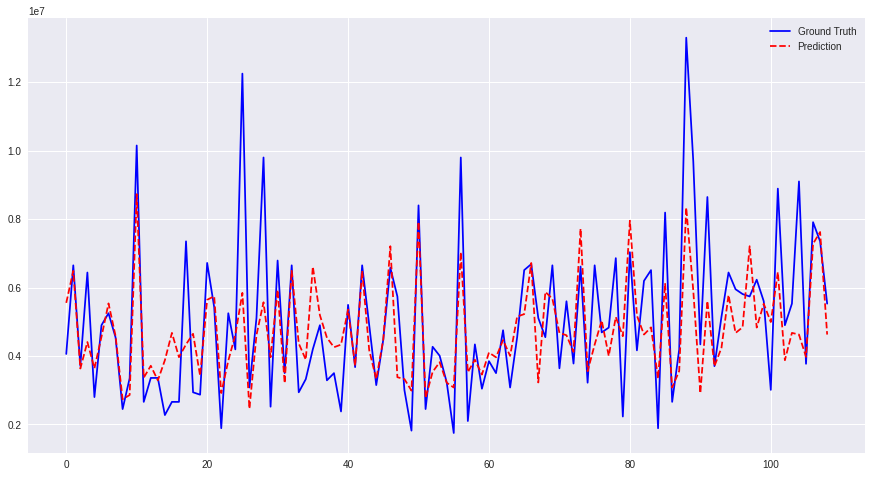

In [242]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,len(ground_pred)), ground_pred['GROUND TRUTH'], 'b', label='Ground Truth')
plt.plot(np.arange(0,len(ground_pred)), ground_pred['PREDICTION'], '--r', label = 'Prediction')
plt.legend()
plt.show()

> From the visualization above, we can see that our model can relatively predict well enough when comparing to our ground truth. Model with Standardization proven better than without-standardization.